# 6.7 Lab 3: PCR and PLS Regression

In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.cross_decomposition import PLSRegression

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
data = pd.read_csv(r'./data/Hitters.csv')
print(data.shape)
data.head()

(322, 21)


,Unnamed: 0,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,...,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,-Andy Allanson,293,66,1,30,29,14,1,293,66,...,30,29,14,A,E,446,33,20,NaN,A
1,-Alan Ashby,315,81,7,24,38,39,14,3449,835,...,321,414,375,N,W,632,43,10,475.0,N
2,-Alvin Davis,479,130,18,66,72,76,3,1624,457,...,224,266,263,A,W,880,82,14,480.0,A
3,-Andre Dawson,496,141,20,65,78,37,11,5628,1575,...,828,838,354,N,E,200,11,3,500.0,N
4,-Andres Galarraga,321,87,10,39,42,30,2,396,101,...,48,46,33,N,E,805,40,4,91.5,N


In [3]:
data.drop('Unnamed: 0',axis = 1,inplace = True)
qual_variables = [col for col in data.columns if data[col].dtype == 'O']
data = pd.get_dummies(data,columns = qual_variables)
print('Shape is ',data.shape)
data.head()

Shape is  (322, 23)


,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,...,PutOuts,Assists,Errors,Salary,League_A,League_N,Division_E,Division_W,NewLeague_A,NewLeague_N
0,293,66,1,30,29,14,1,293,66,1,...,446,33,20,NaN,1,0,1,0,1,0
1,315,81,7,24,38,39,14,3449,835,69,...,632,43,10,475.0,0,1,0,1,0,1
2,479,130,18,66,72,76,3,1624,457,63,...,880,82,14,480.0,1,0,0,1,1,0
3,496,141,20,65,78,37,11,5628,1575,225,...,200,11,3,500.0,0,1,1,0,0,1
4,321,87,10,39,42,30,2,396,101,12,...,805,40,4,91.5,0,1,1,0,0,1


In [4]:
# removing the null values
data.dropna(inplace = True)

In [5]:
X = data.drop('Salary',axis = 1)
y = data['Salary']

## 6.7.1 Principal Components Regression

In [6]:
# we have to scale the predictors before applying pca
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#applying pca
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

In [7]:
print('Shape of data returned by pca is ',X_pca.shape)

Shape of data returned by pca is  (263, 22)


In [8]:
print('Total number of components are - ',len(pca.components_))
# we can see that there are total 22 principal axis. Each features axis is represented as a 22-dimensional vector
# If our dataset was 2-dimensional, than each principal axis ( here 2), would have been a line (2-dimensional vector)

Total number of components are -  22


In [9]:
# Lets see the vriance explained by each of the above mentioned principal components
pca.explained_variance_ratio_*100
#This is not so clear

array([3.33519423e+01, 1.98329668e+01, 1.59398706e+01, 9.00942497e+00,
       7.60093752e+00, 3.81576505e+00, 3.15504103e+00, 2.34828437e+00,
       1.21007079e+00, 1.13336303e+00, 8.39744718e-01, 5.94024833e-01,
       4.35033641e-01, 2.77562127e-01, 2.37062334e-01, 1.27338736e-01,
       6.40680776e-02, 2.21021282e-02, 5.39704206e-03, 3.76186451e-31,
       9.58705122e-32, 1.83849386e-33])

In [10]:
# round it to 1 decimal points
np.round(pca.explained_variance_ratio_*100,1)

# we can see from the output of this cell that the first princiap component explains 33.4% of the variance, whereas the second
# explains about 19.8% of the variance of the dataset. the last few principal components are irrevalent

array([33.4, 19.8, 15.9,  9. ,  7.6,  3.8,  3.2,  2.3,  1.2,  1.1,  0.8,
        0.6,  0.4,  0.3,  0.2,  0.1,  0.1,  0. ,  0. ,  0. ,  0. ,  0. ])

## PCR - principal component regression

#### What we did aboce was actually PCA, in PCR, we use the data we got by PCA and fit a linear regression model to it.

#### we will also select the value of num_component, which is a hyperparamter we feed to PCA, incdicating in how many components 
#### we are going to reduce the dimension of data.

In [11]:
def pcr(X,y):
  scaler = StandardScaler()
  X_scaled = scaler.fit_transform(X)
  num_components = X.shape[1]
  scores = []
  variability_explained = []

  for n_component in range(1,num_components+1):
    pca = PCA(n_components=n_component)
    X_pca = pca.fit_transform(X_scaled)
    lr = LinearRegression()
    scores.append(-np.mean(cross_val_score(lr,X_pca,y,cv = 10,scoring = 'neg_mean_squared_error')))
    variability_explained.append(np.sum(np.round(pca.explained_variance_ratio_*100,1)))
  return scores,variability_explained    

In [12]:
scores,var_explained = pcr(X,y) 

In [13]:
num_components = np.arange(1,X.shape[1]+1)

Text(0.5, 1.0, '% explained by num of components')

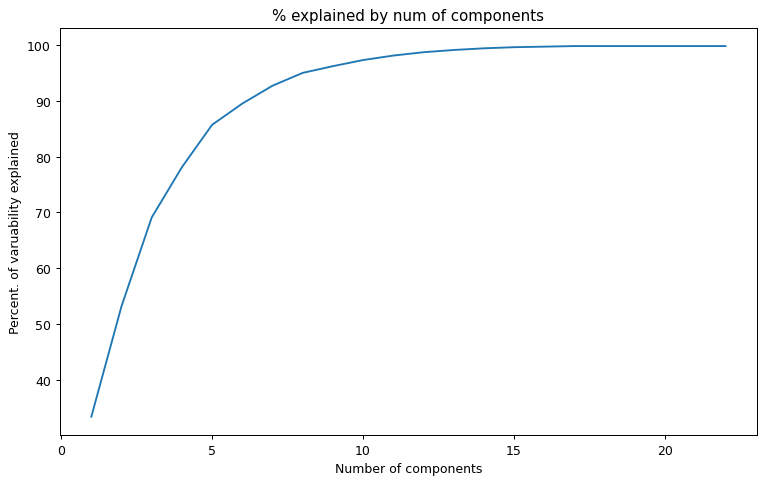

In [15]:
# Lets see the variability explained as function of the num_of_components
plt.figure(figsize = (10,6), dpi=90)
plt.plot(num_components,var_explained)
plt.xlabel('Number of components')
plt.ylabel('Percent. of varuability explained')
plt.title('% explained by num of components')

#### We can see from the above graph that we cannot really choose the value of percentage of variability explained as it is 
#### ever increasing. We will look at cv score now.

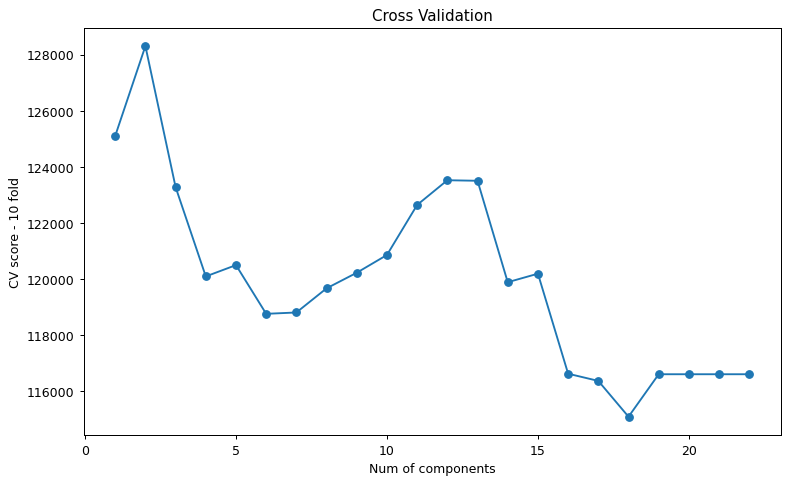

In [16]:
plt.figure(figsize = (10,6), dpi=90)
plt.plot(num_components,scores,marker = 'o')
plt.xlabel('Num of components')
plt.ylabel('CV score - 10 fold')
plt.title('Cross Validation')
plt.xticks = num_components

#### that;s interesting, although the graph looks very distorted, the y has values only between 11600 to 128000
#### The best error is for num_components = 18

## 6.7.2 Partial Least Squares

In [17]:
def pls_regression(X,y):
  num_components = X.shape[1]
  scores = []

  for n_component in range(1,num_components+1):
    scores.append(-np.mean(cross_val_score(PLSRegression(n_components=n_component,scale=True)
                  ,X_pca,y,cv = 10,scoring = 'neg_mean_squared_error')))

  return scores

In [18]:
pls_scores = pls_regression(X,y)

Text(0.5, 1.0, 'PARTIAL LEAST SQUARES')

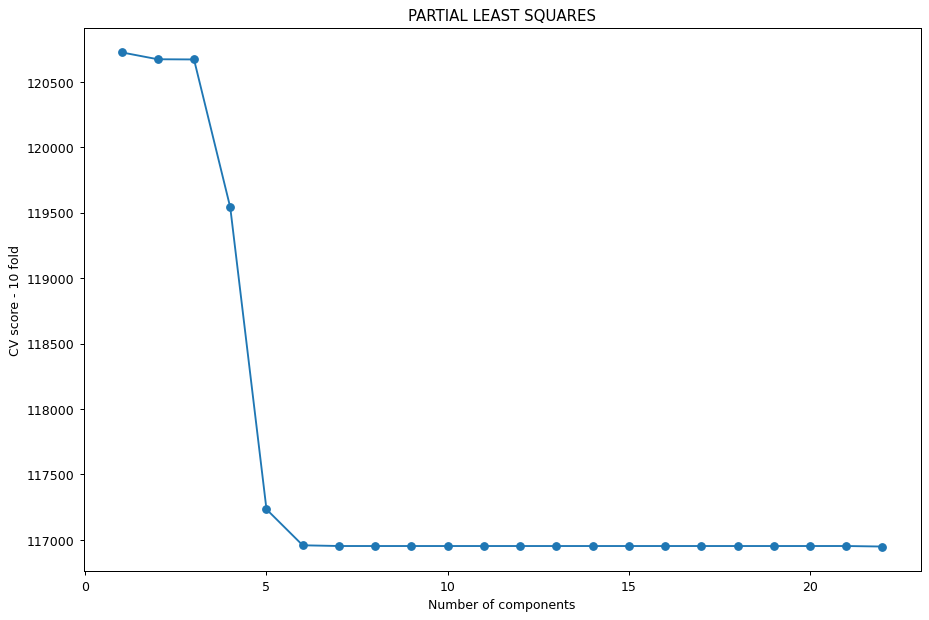

In [20]:
plt.figure(figsize = (12,8), dpi=90)
plt.plot(num_components,pls_scores,marker = 'o')
plt.xlabel('Number of components')
plt.ylabel('CV score - 10 fold')
plt.title('PARTIAL LEAST SQUARES')

#### we can see here that the best result is when num_component = 2